In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import sys 
installation_path = "/content/drive/MyDrive/Colab_Installations_V2"
# The path is being modified so that everything installed in the installation path can now be used without re-installing (in this case, I just need biopython)
sys.path.insert(0,installation_path)
protein_mpnn_path = "/content/drive/MyDrive/Protein_MPNN_Digging/ProteinMPNN/vanilla_proteinmpnn"
sys.path.insert(0,protein_mpnn_path)

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Protein_MPNN_Digging

/content/drive/MyDrive/Protein_MPNN_Digging


In [3]:
import re
import matplotlib.pyplot as plt
import shutil
import warnings
import numpy as np
import torch
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split, Subset
import copy
import torch.nn as nn
import torch.nn.functional as F
import random
import os
from protein_mpnn_utils import loss_nll, loss_smoothed, gather_edges, gather_nodes, gather_nodes_t, cat_neighbors_nodes, _scores, _S_to_seq, tied_featurize
from protein_mpnn_utils import StructureDataset, StructureDatasetPDB, ProteinMPNN
from Bio.PDB import *

device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

In [4]:
import pandas as pd
from tqdm.notebook import tqdm
from Bio.PDB.Polypeptide import *
from string import ascii_uppercase

In [5]:
weights_path = os.path.join(protein_mpnn_path,"vanilla_model_weights")
model_name = "v_48_020"
checkpoint_path = os.path.join(weights_path,model_name+".pt")

In [6]:
# Now, load and dig into the checkpoint object
checkpoint = torch.load(checkpoint_path, map_location=device) 

In [ ]:
hidden_dim = 128
num_layers = 3 
# Seems like, backbone_noise is set to 0 at inference path which seems logical
backbone_noise=0.00
mpnn_model = ProteinMPNN(num_letters=21, node_features=hidden_dim, edge_features=hidden_dim, hidden_dim=hidden_dim, num_encoder_layers=num_layers, num_decoder_layers=num_layers, augment_eps=backbone_noise, k_neighbors=checkpoint['num_edges'])
mpnn_model.to(device)
mpnn_model.load_state_dict(checkpoint['model_state_dict'])
mpnn_model.eval()

In [8]:
print(checkpoint['model_state_dict'].keys())

odict_keys(['features.embeddings.linear.weight', 'features.embeddings.linear.bias', 'features.edge_embedding.weight', 'features.norm_edges.weight', 'features.norm_edges.bias', 'W_e.weight', 'W_e.bias', 'W_s.weight', 'encoder_layers.0.norm1.weight', 'encoder_layers.0.norm1.bias', 'encoder_layers.0.norm2.weight', 'encoder_layers.0.norm2.bias', 'encoder_layers.0.norm3.weight', 'encoder_layers.0.norm3.bias', 'encoder_layers.0.W1.weight', 'encoder_layers.0.W1.bias', 'encoder_layers.0.W2.weight', 'encoder_layers.0.W2.bias', 'encoder_layers.0.W3.weight', 'encoder_layers.0.W3.bias', 'encoder_layers.0.W11.weight', 'encoder_layers.0.W11.bias', 'encoder_layers.0.W12.weight', 'encoder_layers.0.W12.bias', 'encoder_layers.0.W13.weight', 'encoder_layers.0.W13.bias', 'encoder_layers.0.dense.W_in.weight', 'encoder_layers.0.dense.W_in.bias', 'encoder_layers.0.dense.W_out.weight', 'encoder_layers.0.dense.W_out.bias', 'encoder_layers.1.norm1.weight', 'encoder_layers.1.norm1.bias', 'encoder_layers.1.norm2.

In [10]:
# Parse and create dictionaries for all the mutations in PremPS 2648
# This dictionary will be a dictionary of dictionaries, where outer-dict keys will be pdbid+mutchain and inner-dict keys will be (wild+pos+mut) and ddg
# the icodes can be brought to picture later
# this "two_level_dict" is literally used everywhere throughout this code for storing all the numbers that are compared with each other under feature-specific keys
dataset = pd.read_csv("/content/drive/MyDrive/ACCRE_PyRun_Setup/Data_s669_with_predictions.csv")


pdbIdsChains = list(dataset["Protein"])

pdbIds = []
mutChains = []

for pdbIdChain in pdbIdsChains:
    pdbIds.append(pdbIdChain[0:-1])
    mutChains.append(pdbIdChain[-1])

mutations = list(dataset["PDB_Mut"])
ddgs = list(dataset["DDG_checked_dir"])

two_level_dict = {}

for pdbId, mutChain, mutation, ddg in tqdm(zip(pdbIds,mutChains,mutations,ddgs)):
    pos = [int(s) for s in re.findall('-?\d+',mutation)][0]
    wild = mutation[0]
    mut = mutation[len(mutation)-1]

    pdbId = pdbId.lower()

    inner_dict = {}
    inner_dict["mut"] = f"{wild}{pos}{mut}"
    inner_dict["ddg"] = float(ddg)
    outer_key = f"{pdbId}{mutChain}"
    if outer_key not in two_level_dict:
        two_level_dict[f"{pdbId}{mutChain}"] = [inner_dict]
    else:
        two_level_dict[f"{pdbId}{mutChain}"].append(inner_dict)

0it [00:00, ?it/s]

In [11]:
# create a seqres to position mapping dictionary
# This dictionary will be a dictionary of dictionaries, where outer-dict keys will be pdbid+mutchain and inner-dict key will be (wild+pos) and value of 0-indexed position
# the icodes can be brought to picture later
mapping_dict = {}
pdbDirectory = "/content/drive/MyDrive/ACCRE_PyRun_Setup/S_669_PDB_Files"
parser = PDBParser(QUIET=True)
# some proteins need to be skipped for now due to ICODE related discrapency
proteins_to_skip = []

for filename in tqdm(os.listdir(pdbDirectory)):
    filepath = os.path.join(pdbDirectory,filename)
    structure = parser.get_structure(id=filename.split(".")[0],file=filepath)
    model = structure[0]
    inner_dict = {}
    outer_key = filename.split(".")[0]
    skip_flag = False
    # single chain-assumption in action again
    for chain in model:
        for i,residue in enumerate(chain):
            inner_key = f"{three_to_one(residue.get_resname())}{residue.get_id()[1]}"
            if inner_key not in inner_dict:
                inner_dict[inner_key] = i
            else:
                # For "2immA:N31" and "1lveA:S27", I have been fucked
                # Need to think whether this will effect other positions or I can just avoid these two-protein related mutations for now?
                # Let me just avoid these two proteins for now
                print("YOU HAVE JUST BEEN FUCKED BY ICODE")
                print(f"{outer_key}:{inner_key}")
                skip_flag = True
    # The ICODE related problematic proteins will not be considered for now
    if not skip_flag:
        mapping_dict[outer_key] = inner_dict
    else:
        proteins_to_skip.append(outer_key)

  0%|          | 0/93 [00:00<?, ?it/s]

In [12]:
# changing this "parse_PDB_biounits()" function locally for addressing the fucked up integer named chain problem  
def parse_PDB_biounits(x, atoms=['N', 'CA', 'C'], chain=None):
    '''
    input:  x = PDB filename
            atoms = atoms to extract (optional)
    output: (length, atoms, coords=(x,y,z)), sequence
    '''
    alpha_1 = list("ARNDCQEGHILKMFPSTWYV-")
    states = len(alpha_1)
    alpha_3 = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE',
               'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL', 'GAP']

    # The following dictionaries are mapping from one-letter to 0-20 index,
    # three-letter to 0-20 index,
    # 0-20 index to one-letter,
    # one-letter to three-letter, and vice-versa
    aa_1_N = {a: n for n, a in enumerate(alpha_1)}
    aa_3_N = {a: n for n, a in enumerate(alpha_3)}
    aa_N_1 = {n: a for n, a in enumerate(alpha_1)}
    aa_1_3 = {a: b for a, b in zip(alpha_1, alpha_3)}
    aa_3_1 = {b: a for a, b in zip(alpha_1, alpha_3)}

    def AA_to_N(x):
        # ["ARND"] -> [[0,1,2,3]]
        x = np.array(x);
        if x.ndim == 0: x = x[None]
        return [[aa_1_N.get(a, states - 1) for a in y] for y in x]

    def N_to_AA(x):
        # [[0,1,2,3]] -> ["ARND"]
        x = np.array(x);
        if x.ndim == 1: x = x[None]
        return ["".join([aa_N_1.get(a, "-") for a in y]) for y in x]

    xyz, seq, min_resn, max_resn = {}, {}, 1e6, -1e6
    for line in open(x, "rb"):
        line = line.decode("utf-8", "ignore").rstrip()

        if line[:6] == "HETATM" and line[17:17 + 3] == "MSE":
            line = line.replace("HETATM", "ATOM  ")
            line = line.replace("MSE", "MET")

        if line[:4] == "ATOM":
            ch = line[21:22]
            # If the input chain is not in the PDB file, which can be the case if the target chains are named differently in the runner script,
            # this line will cause the output to have literally no information, this is the case for integer named chains
            # that does not mean that this line is not doing its job correctly, this is just a constraint that input chain names and
            # chain names in the PDB file have to be congruent
            # If "ch" is an integer, map it to alphabet, because input "chain" has been converted to alphabet
            # In rare cases, some PDB files number chains with 1,2,3 instead of A,B,C
            # This "loc_dict" dictionary contains integer to alphabet mapping for weird as fuck integer chain names
            # This conversion will be done only when  chain name is actually an integer
            if ord(ch) >= 49 and ord(ch) <= 57:
                loc_dict = {(idx+1):ch for idx,ch in enumerate(ascii_uppercase)}
                ch =  str(loc_dict[int(ch)])
            if ch == chain or chain is None:
                atom = line[12:12 + 4].strip()
                resi = line[17:17 + 3]
                resn = line[22:22 + 5].strip()
                x, y, z = [float(line[i:(i + 8)]) for i in [30, 38, 46]]

                if resn[-1].isalpha():
                    resa, resn = resn[-1], int(resn[:-1]) - 1
                else:
                    resa, resn = "", int(resn) - 1
                #         resn = int(resn)
                if resn < min_resn:
                    min_resn = resn
                if resn > max_resn:
                    max_resn = resn
                if resn not in xyz:
                    xyz[resn] = {}
                if resa not in xyz[resn]:
                    xyz[resn][resa] = {}
                if resn not in seq:
                    seq[resn] = {}
                if resa not in seq[resn]:
                    seq[resn][resa] = resi

                if atom not in xyz[resn][resa]:
                    xyz[resn][resa][atom] = np.array([x, y, z])

    # convert to numpy arrays, fill in missing values
    seq_, xyz_ = [], []
    try:
        for resn in range(min_resn, max_resn + 1):
            if resn in seq:
                for k in sorted(seq[resn]): seq_.append(aa_3_N.get(seq[resn][k], 20))
            else:
                seq_.append(20)
            if resn in xyz:
                for k in sorted(xyz[resn]):
                    for atom in atoms:
                        if atom in xyz[resn][k]:
                            xyz_.append(xyz[resn][k][atom])
                        else:
                            xyz_.append(np.full(3, np.nan))
            else:
                for atom in atoms: xyz_.append(np.full(3, np.nan))
        return np.array(xyz_).reshape(-1, len(atoms), 3), N_to_AA(np.array(seq_))
    except TypeError:
        return 'no_chain', 'no_chain'

# Took this part out of "utils.py", and put here so that smalll changes can be made to address pesky issues like
# integer named chain, and shit like those
def parse_PDB(path_to_pdb, input_chain_list=None):
    c=0
    pdb_dict_list = []
    init_alphabet = ['A', 'B', 'C', 'D', 'E', 'F', 'G','H', 'I', 'J','K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T','U', 'V','W','X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g','h', 'i', 'j','k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't','u', 'v','w','x', 'y', 'z']
    extra_alphabet = [str(item) for item in list(np.arange(300))]
    chain_alphabet = init_alphabet + extra_alphabet
     
    if input_chain_list:
        chain_alphabet = input_chain_list  
 

    biounit_names = [path_to_pdb]
    # Each of the biounits is a separate PDB file, so for running with a single PDB file like from colab, this loop will be executed only once
    for biounit in biounit_names:
        my_dict = {}
        s = 0
        concat_seq = ''
        concat_N = []
        concat_CA = []
        concat_C = []
        concat_O = []
        concat_mask = []
        coords_dict = {} 
        # This loop will be executed only once for single chain DDG type cases
        for letter in chain_alphabet:
            xyz, seq = parse_PDB_biounits(biounit, atoms=['N','CA','C','O'], chain=letter)
            if type(xyz) != str:
                concat_seq += seq[0]
                my_dict['seq_chain_'+letter]=seq[0]
                coords_dict_chain = {}
                coords_dict_chain['N_chain_'+letter]=xyz[:,0,:].tolist()
                coords_dict_chain['CA_chain_'+letter]=xyz[:,1,:].tolist()
                coords_dict_chain['C_chain_'+letter]=xyz[:,2,:].tolist()
                coords_dict_chain['O_chain_'+letter]=xyz[:,3,:].tolist()
                my_dict['coords_chain_'+letter]=coords_dict_chain
                s += 1
        fi = biounit.rfind("/")
        my_dict['name']=biounit[(fi+1):-4]
        my_dict['num_of_chains'] = s
        my_dict['seq'] = concat_seq
        if s <= len(chain_alphabet):
            pdb_dict_list.append(my_dict)
            c+=1
    return pdb_dict_list

In [13]:
# read in the PDB files from the directory where the S_2648 PDB Files are stored, and set-them up one by one for featuirization, and passing through the model
pdbDirectory = "/content/drive/MyDrive/ACCRE_PyRun_Setup/S_669_PDB_Files"
parser = PDBParser(QUIET=True)
for i,filename in tqdm(enumerate(os.listdir(pdbDirectory))):
    #ICODE related problematic proteins will be skipped from analysis for now
    if (filename.split(".")[0] not in proteins_to_skip):
        # if i > 70:
        #     break
        filepath = os.path.join(pdbDirectory,filename)
        structure = parser.get_structure(id=filename.split(".")[0],file=filepath)
        model = structure[0]
        
        # Since there is only one chain, and that same chain is both fixed designable for different residues, extracting that name, and putting them in pertinent lists
        # taking chainname from filename since one of the files "1rtpA.pdb" has chain name with "1" instead of "A"
        # fuck you motherfucking fucked up PDB file submitter. Have you shoved your head into your ass?
        chain_name = (filename.split(".")[0])[-1]
        fixed_chain_list = []
        # the trick is to put the single chain as designable chain, and then create the "fixed_positions_dict" dictionary  
        designed_chain_list = [chain_name]
        chain_list = list(set(designed_chain_list + fixed_chain_list))

        # Using the programs custome PDB parser for processing the PDB files
        pdb_dict_list = parse_PDB(filepath, input_chain_list=chain_list)
        # tacking max_length parameter value from the original colab notebook since I need to process all residues at the same time
        # all the PDB files can technically be processed together and put inside the dataset_valid list-like object, but right now
        # I am trying to keep everything consistent and simple
        # Each element of dataset_valid is a dictionary 
        dataset_valid = StructureDatasetPDB(pdb_dict_list, truncate=None, max_length=20000)

        # Simplying the sequence generation loop
        protein = dataset_valid[0]

        wildtype_seq = protein[f"seq_chain_{designed_chain_list[0]}"]

        # If there are gaps in the wildtype_seq "seq", remove those positions from both the "seq", "" and ('coords_chain_{designed_chain_list[0]}'), 
        # and ('seq_chain_{designed_chain_list[0]}') of the "protein"
        # print(protein.keys())
        # protein is a dict with keys(['seq_chain_A', 'coords_chain_A', 'name', 'num_of_chains', 'seq'])
        # "seq_chain" and "seq_all" are both strings of the same length where gapped positions need to be identified and removed
        seq_chain = protein[f"seq_chain_{designed_chain_list[0]}"]
        seq_all = protein[f"seq"]
        # "coordinates_chain" is a dict with keys(['N_chain_A', 'CA_chain_A', 'C_chain_A', 'O_chain_A'])
        coordinates_chain = protein[f"coords_chain_{designed_chain_list[0]}"]

        
        # The following four variables are lists of length equal to seq_chain and seq_all length
        # Therefore, the gapped positions can be retrived from seq_chain and removed from everything accordingly
        N_chain = coordinates_chain[f"N_chain_{designed_chain_list[0]}"]
        CA_chain = coordinates_chain[f"CA_chain_{designed_chain_list[0]}"]
        C_chain = coordinates_chain[f"C_chain_{designed_chain_list[0]}"]
        O_chain = coordinates_chain[f"O_chain_{designed_chain_list[0]}"]

        # delete everything related to gapped positions now
        # at first, find out the positions that are gapped
        # these gapped positions are absolutely messed up fucked up artifact of some kind of sophistification 
        # provided by proteinMPNN, FUCK YOU motherfucking oversmart CODERS
        N_chain = [v for i,v in enumerate(N_chain) if seq_chain[i] != "-"]
        CA_chain = [v for i,v in enumerate(CA_chain) if seq_chain[i] != "-"]
        C_chain = [v for i,v in enumerate(C_chain) if seq_chain[i] != "-"]
        O_chain = [v for i,v in enumerate(O_chain) if seq_chain[i] != "-"]
        seq_all = [v for i,v in enumerate(seq_all) if seq_chain[i] != "-"]
        seq_chain = [v for i,v in enumerate(seq_chain) if seq_chain[i] != "-"]

        # Now, finally, pack everything back to the dictionary "protein"
        protein[f"seq_chain_{designed_chain_list[0]}"] = seq_chain
        protein[f"seq"] = seq_all
        coordinates_chain[f"N_chain_{designed_chain_list[0]}"] = N_chain
        coordinates_chain[f"CA_chain_{designed_chain_list[0]}"] = CA_chain
        coordinates_chain[f"C_chain_{designed_chain_list[0]}"] = C_chain
        coordinates_chain[f"O_chain_{designed_chain_list[0]}"] = O_chain
        protein[f"coords_chain_{designed_chain_list[0]}"] = coordinates_chain

        # At this point, probably need to put None values in a lot of parameters that are not relevant to my usecase, but need to be sent to featurizer before running model forward
        # For now, I will not tie positions together
        tied_positions_dict = None
        pssm_dict = None
        omit_AA_dict = None
        bias_AA_dict = None
        tied_positions_dict = None
        bias_by_res_dict = None
        alphabet = 'ACDEFGHIKLMNPQRSTVWYX'
        bias_AAs_np = np.zeros(len(alphabet))

        chain_id_dict = {}
        chain_id_dict[pdb_dict_list[0]['name']]= (designed_chain_list, fixed_chain_list)

        BATCH_COPIES = 1

        batch_clones = [copy.deepcopy(protein) for i in range(BATCH_COPIES)]

        # "muts_for_prot" is a list with information about all the mutations in "protein", whose sequence only version is "wildtype_seq" 
        muts_for_prot = two_level_dict[filename.split(".")[0]]
        # "cur_map_dict" will give the 0-based sequence index for the mutations, which will be almost directly used for masking and then running the model
        # 1-based indexing needed for the fixed position
        cur_map_dict = mapping_dict[filename.split(".")[0]]

        for mut in muts_for_prot:
            wild_aa = mut["mut"][0]
            # (+1) because we need to pass 1-based indexing to tied_featurize() method
            seq_pos = cur_map_dict[mut["mut"][0:-1]] + 1
            # only need to mask the mutated position position in "wildtype_seq" for now
            fixed_positions_dict = {}
            fixed_positions_dict[protein["name"]] = {}
            f_list = []
            for ind_fixed in range(0,len(seq_chain)):
                if (ind_fixed + 1) not in [seq_pos]:
                    f_list.append(ind_fixed + 1)
            # What the fuck have I done here?
            # f_list.append(seq_pos)
            fixed_positions_dict[protein["name"]][filename.split(".")[0][-1]] = f_list
            # finally, had to take chain-name from filename instead of biopython parsing to get rid of chain-name with "1" instead of "A" in "1rtpA.pdb"
            X, S, mask, lengths, chain_M, chain_encoding_all, chain_list_list, visible_list_list, masked_list_list, masked_chain_length_list_list, chain_M_pos, \
            omit_AA_mask, residue_idx, dihedral_mask, tied_pos_list_of_lists_list, pssm_coef, pssm_bias, pssm_log_odds_all, bias_by_res_all, tied_beta  \
            = tied_featurize(batch_clones, device, chain_id_dict, fixed_positions_dict, omit_AA_dict, tied_positions_dict, pssm_dict, bias_by_res_dict)
            randn_1 = torch.randn(chain_M.shape, device=X.device)
            log_probs = mpnn_model(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1)
            # Adding the log_probs to the same inner dictionary where DDG values exist for easier comparison
            mut["log_prob"] = log_probs.cpu().data.numpy()

0it [00:00, ?it/s]

In [ ]:
# # read in the PDB files from the directory where the S_2648 PDB Files are stored, and set-them up one by one for featuirization, and passing through the model
# pdbDirectory = "/content/drive/MyDrive/ACCRE_PyRun_Setup/S_2648_PDB_Files"
# parser = PDBParser(QUIET=True)
# for i,filename in tqdm(enumerate(os.listdir(pdbDirectory))):
#     #ICODE related problematic proteins will be skipped from analysis for now
#     if (filename.split(".")[0] not in proteins_to_skip):
#         if i > 7:
#             break
#         filepath = os.path.join(pdbDirectory,filename)
#         structure = parser.get_structure(id=filename.split(".")[0],file=filepath)
#         model = structure[0]
        
#         # Since there is only one chain, and that same chain is both fixed designable for different residues, extracting that name, and putting them in pertinent lists
#         # taking chainname from filename since one of the files "1rtpA.pdb" has chain name with "1" instead of "A"
#         # fuck you motherfucking fucked up PDB file submitter. Have you shoved your head into your ass?
#         chain_name = (filename.split(".")[0])[-1]
#         fixed_chain_list = []
#         # the trick is to put the single chain as designable chain, and then create the "fixed_positions_dict" dictionary  
#         designed_chain_list = [chain_name]
#         chain_list = list(set(designed_chain_list + fixed_chain_list))

#         # Using the programs custome PDB parser for processing the PDB files
#         pdb_dict_list = parse_PDB(filepath, input_chain_list=chain_list)
#         # tacking max_length parameter value from the original colab notebook since I need to process all residues at the same time
#         # all the PDB files can technically be processed together and put inside the dataset_valid list-like object, but right now
#         # I am trying to keep everything consistent and simple
#         # Each element of dataset_valid is a dictionary 
#         dataset_valid = StructureDatasetPDB(pdb_dict_list, truncate=None, max_length=20000)

#         # Simplying the sequence generation loop
#         protein = dataset_valid[0]

#         wildtype_seq = protein[f"seq_chain_{designed_chain_list[0]}"]

#         # If there are gaps in the wildtype_seq "seq", remove those positions from both the "seq", "" and ('coords_chain_{designed_chain_list[0]}'), 
#         # and ('seq_chain_{designed_chain_list[0]}') of the "protein"
#         # print(protein.keys())
#         # protein is a dict with keys(['seq_chain_A', 'coords_chain_A', 'name', 'num_of_chains', 'seq'])
#         # "seq_chain" and "seq_all" are both strings of the same length where gapped positions need to be identified and removed
#         seq_chain = protein[f"seq_chain_{designed_chain_list[0]}"]
#         seq_all = protein[f"seq"]
#         # "coordinates_chain" is a dict with keys(['N_chain_A', 'CA_chain_A', 'C_chain_A', 'O_chain_A'])
#         coordinates_chain = protein[f"coords_chain_{designed_chain_list[0]}"]

        
#         # The following four variables are lists of length equal to seq_chain and seq_all length
#         # Therefore, the gapped positions can be retrived from seq_chain and removed from everything accordingly
#         N_chain = coordinates_chain[f"N_chain_{designed_chain_list[0]}"]
#         CA_chain = coordinates_chain[f"CA_chain_{designed_chain_list[0]}"]
#         C_chain = coordinates_chain[f"C_chain_{designed_chain_list[0]}"]
#         O_chain = coordinates_chain[f"O_chain_{designed_chain_list[0]}"]

#         # delete everything related to gapped positions now
#         # at first, find out the positions that are gapped
#         # these gapped positions are absolutely messed up fucked up artifact of some kind of sophistification 
#         # provided by proteinMPNN, FUCK YOU motherfucking oversmart CODERS
#         N_chain = [v for i,v in enumerate(N_chain) if seq_chain[i] != "-"]
#         CA_chain = [v for i,v in enumerate(CA_chain) if seq_chain[i] != "-"]
#         C_chain = [v for i,v in enumerate(C_chain) if seq_chain[i] != "-"]
#         O_chain = [v for i,v in enumerate(O_chain) if seq_chain[i] != "-"]
#         seq_all = [v for i,v in enumerate(seq_all) if seq_chain[i] != "-"]
#         seq_chain = [v for i,v in enumerate(seq_chain) if seq_chain[i] != "-"]

#         # Now, finally, pack everything back to the dictionary "protein"
#         protein[f"seq_chain_{designed_chain_list[0]}"] = seq_chain
#         protein[f"seq"] = seq_all
#         coordinates_chain[f"N_chain_{designed_chain_list[0]}"] = N_chain
#         coordinates_chain[f"CA_chain_{designed_chain_list[0]}"] = CA_chain
#         coordinates_chain[f"C_chain_{designed_chain_list[0]}"] = C_chain
#         coordinates_chain[f"O_chain_{designed_chain_list[0]}"] = O_chain
#         protein[f"coords_chain_{designed_chain_list[0]}"] = coordinates_chain

#         # At this point, probably need to put None values in a lot of parameters that are not relevant to my usecase, but need to be sent to featurizer before running model forward
#         # For now, I will not tie positions together
#         tied_positions_dict = None
#         pssm_dict = None
#         omit_AA_dict = None
#         bias_AA_dict = None
#         tied_positions_dict = None
#         bias_by_res_dict = None
#         alphabet = 'ACDEFGHIKLMNPQRSTVWYX'
#         bias_AAs_np = np.zeros(len(alphabet))

#         chain_id_dict = {}
#         chain_id_dict[pdb_dict_list[0]['name']]= (designed_chain_list, fixed_chain_list)

#         BATCH_COPIES = 1

#         batch_clones = [copy.deepcopy(protein) for i in range(BATCH_COPIES)]

#         # "muts_for_prot" is a list with information about all the mutations in "protein", whose sequence only version is "wildtype_seq" 
#         muts_for_prot = two_level_dict[filename.split(".")[0]]
#         # "cur_map_dict" will give the 0-based sequence index for the mutations, which will be almost directly used for masking and then running the model
#         # 1-based indexing needed for the fixed position
#         cur_map_dict = mapping_dict[filename.split(".")[0]]

#         for mut in muts_for_prot:
#             wild_aa = mut["mut"][0]
#             # (+1) because we need to pass 1-based indexing to tied_featurize() method
#             seq_pos = cur_map_dict[mut["mut"][0:-1]] + 1
#             # only need to mask the mutated position position in "wildtype_seq" for now
#             fixed_positions_dict = {}
#             fixed_positions_dict[protein["name"]] = {}
#             f_list = []
#             for ind_fixed in range(0,len(seq_chain)):
#                 if (ind_fixed + 1) not in [seq_pos]:
#                     f_list.append(ind_fixed + 1)
#             # What the fuck have I done here?
#             # f_list.append(seq_pos)
#             fixed_positions_dict[protein["name"]][filename.split(".")[0][-1]] = f_list
#             # finally, had to take chain-name from filename instead of biopython parsing to get rid of chain-name with "1" instead of "A" in "1rtpA.pdb"
#             X, S, mask, lengths, chain_M, chain_encoding_all, chain_list_list, visible_list_list, masked_list_list, masked_chain_length_list_list, chain_M_pos, \
#             omit_AA_mask, residue_idx, dihedral_mask, tied_pos_list_of_lists_list, pssm_coef, pssm_bias, pssm_log_odds_all, bias_by_res_all, tied_beta  \
#             = tied_featurize(batch_clones, device, chain_id_dict, fixed_positions_dict, omit_AA_dict, tied_positions_dict, pssm_dict, bias_by_res_dict)
#             randn_1 = torch.randn(chain_M.shape, device=X.device)
#             log_probs = mpnn_model(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1)
#             # Adding the log_probs to the same inner dictionary where DDG values exist for easier comparison
#             mut["log_prob"] = log_probs.cpu().data.numpy()

In [ ]:
# Save the incomplete "two_level_dict" as pickle file for a quick dirty comparison
# import pickle
# with open("res_dict.pickle","wb") as f:
#     pickle.dump(two_level_dict,f)

In [ ]:
# import pickle
# with open("res_dict.pickle","rb") as f:
#     two_level_dict = pickle.load(f)

In [14]:
from scipy.stats import entropy
alpha_list = list("ACDEFGHIKLMNPQRSTVWYX")
# The following dictionary will be used for fetching out the log-probabilities corresponding to the wild-type and mutated residues at the mutation positions
aa_to_N = {a:n for n,a in enumerate(alpha_list)}
# This list will contain the experimental ddg values for the mutations for which two-level dict contains information regarding log_probabilities
true_vals = []
# This list will contain (wild_proba,mut_proba) tuples for the mutations for which two-level dict contains information regarding log_probabilities
wild_mut_log_probabilities = []
# saving max probabilites for debugging
max_log_probabilities = []
# Want to add entropy of the position with some kind of weight (maybe, just a for loop for checking weight combinations that sum to 1?)
position_entropies = []
for prot,muts in two_level_dict.items():
    if prot not in proteins_to_skip:
        try:
            cur_map_dict = mapping_dict[prot]
        except:
            continue
        for mut in muts:
            # only fetching those mutations that have corresponding log-probabilities calculated and saved as values of "log_prob" key
            if "log_prob" in mut:
                wild = mut["mut"][0] 
                alternate = mut["mut"][-1]
                true_vals.append(mut["ddg"])
                sequence_index_of_mutation = cur_map_dict[mut["mut"][0:-1]]
                position_log_probabilities = mut["log_prob"][0,sequence_index_of_mutation,:]
                wild_mut_log_probabilities.append((position_log_probabilities[aa_to_N[wild]],position_log_probabilities[aa_to_N[alternate]]))
                max_log_probabilities.append(position_log_probabilities.max())
                position_entropies.append(entropy(np.exp(position_log_probabilities)))
    # Take only those mutations where "log_prob" is available and make a quick comparison for correlation plot
    # Next, read in PSSM, and do same
    # Then tree-way plot
    # Then linear regression with PSSM + log_prob for the specific positions
    # Then log-prob to probability distribution, and entropy calculation

In [15]:
# let us also look at the energy of the most probable amino acid in those mutation positions
wild_energies = []
mut_energies = []
min_energies = []
experimental_energies = []
entropy_conservations = []
# Now, add entropy of the position
for true, estimate, max_prob, entropy_conservation in zip(true_vals,wild_mut_log_probabilities,max_log_probabilities,position_entropies):
    experimental_energies.append(true)
    wild_energies.append(estimate[0]*-1)
    mut_energies.append(estimate[1]*-1)
    min_energies.append(max_prob*-1)
    entropy_conservations.append(entropy_conservation*-1)

In [16]:
from scipy.stats import pearsonr

In [17]:
wild_energies = np.array(wild_energies)
mut_energies = np.array(mut_energies)
min_energies = np.array(min_energies)
experimental_energies = np.array(experimental_energies)
mut_wild_predictions = mut_energies - wild_energies
mut_min_predictions = mut_energies - min_energies
entropy_predictions = np.array(entropy_conservations)
print(pearsonr(experimental_energies,mut_wild_predictions))
print(pearsonr(experimental_energies,mut_min_predictions))
print(pearsonr(experimental_energies,entropy_predictions))

(-0.33856786824323354, 1.4166247948339322e-18)
(-0.29345482710447945, 3.8810968004429874e-14)
(-0.26080450330347416, 2.2197196517655826e-11)


In [18]:
# Now combine "mut_wild_predictions" and "entropy_predictions" using weight combinations from 0 to 1 in 0.05 increments so that they some to one
# so, when one weight is x, the other weight is automatically (1-x)
# The keys of this dictionary will be (term1_coeff,term2_coeff) tuples, and values will be the observed correlations 
coefficient_result_dictionary = {}
for i in np.arange(0.0,1.000001,0.005):
    term1_coeff = round(i,2)
    term2_coeff = round((1.000001 - i),2)
    local_preds = (term1_coeff*mut_wild_predictions) + (term2_coeff*entropy_predictions)
    coefficient_result_dictionary[(term1_coeff,term2_coeff)] = round(pearsonr(experimental_energies,local_preds)[0],2) 

In [19]:
coefficient_result_dictionary

{(0.0, 1.0): -0.26,
 (0.01, 0.99): -0.27,
 (0.02, 0.98): -0.27,
 (0.02, 0.99): -0.27,
 (0.03, 0.97): -0.27,
 (0.04, 0.96): -0.28,
 (0.04, 0.97): -0.28,
 (0.05, 0.95): -0.28,
 (0.06, 0.94): -0.29,
 (0.06, 0.95): -0.29,
 (0.07, 0.93): -0.29,
 (0.08, 0.92): -0.29,
 (0.08, 0.93): -0.29,
 (0.09, 0.91): -0.3,
 (0.1, 0.9): -0.3,
 (0.1, 0.91): -0.3,
 (0.11, 0.89): -0.3,
 (0.12, 0.88): -0.3,
 (0.12, 0.89): -0.3,
 (0.13, 0.87): -0.31,
 (0.14, 0.86): -0.31,
 (0.14, 0.87): -0.31,
 (0.15, 0.85): -0.31,
 (0.16, 0.84): -0.31,
 (0.16, 0.85): -0.31,
 (0.17, 0.83): -0.32,
 (0.18, 0.82): -0.32,
 (0.18, 0.83): -0.32,
 (0.19, 0.81): -0.32,
 (0.2, 0.8): -0.32,
 (0.2, 0.81): -0.32,
 (0.21, 0.79): -0.32,
 (0.22, 0.78): -0.32,
 (0.22, 0.79): -0.32,
 (0.23, 0.77): -0.32,
 (0.24, 0.76): -0.33,
 (0.24, 0.77): -0.33,
 (0.25, 0.75): -0.33,
 (0.26, 0.74): -0.33,
 (0.26, 0.75): -0.33,
 (0.27, 0.73): -0.33,
 (0.28, 0.72): -0.33,
 (0.28, 0.73): -0.33,
 (0.29, 0.71): -0.33,
 (0.29, 0.72): -0.33,
 (0.3, 0.7): -0.33,
 (0.

In [20]:
# let me get PSSM values and do some comparison quickly
# getting the PSSM extraction functions from my custom model data processing scripts
from string import ascii_uppercase

# In rare cases, some PDB files number chains with 1,2,3 instead of A,B,C
def convertChainFromAlphabetToNumber(alphabet):
    mappingDict = {ch:(idx+1) for idx,ch in enumerate(ascii_uppercase)}
    return str(mappingDict[alphabet])

# Before executing this function, the PSSM files with naming format "pdbIdchain.pssm" needs to be stored
# in the pssm_dir
def returnPSSMArray(pdbIdPlusChain,pssm_dir="train_pssm_dir",convert_upper = False):
#     Currently, assuming that the pssm file names contain pdbId in upper case
    if convert_upper:
        fileName = pdbIdPlusChain.upper() + ".pssm"
    else:
        fileName = pdbIdPlusChain + ".pssm"
    try:
        fullPath = os.path.join(pssm_dir,fileName)
        f = open(fullPath)
    except:
        fileName = pdbIdPlusChain[0:4].upper() + str(convertChainFromAlphabetToNumber(pdbIdPlusChain[4])) + ".pssm" 
        fullPath = os.path.join(pssm_dir,fileName)
        f = open(fullPath)
        
# #     all the target lines in the PSSM files have (2+20+20+2=44) strings after line.split()
    target_lines = [line.split() for line in f.readlines() if (len(line.split()))==44]
    number_of_residues = len(target_lines)
    
    pssm_features = np.zeros((number_of_residues,20))

    for idx,line in enumerate(target_lines):
        pssm_features[idx,:] = line[2:22]

    f.close()
    
    return pssm_features

# This function also seems necessary for extracting the two pssm values
# Must review the three pssm feature functions (this one and the two above) later
# These functions seem to be taking up a lot of time....must review
def returnPSSMMapping(residue):
    pssm_letter_to_index_dict = {"A" : 0,   
    "R" : 1,
    "N" : 2,
    "D" : 3,
    "C" : 4,
    "Q" : 5,
    "E" : 6,
    "G" : 7,
    "H" : 8,
    "I" : 9,
    "L" : 10,
    "K" : 11,
    "M" : 12,
    "F" : 13,
    "P" : 14,
    "S" : 15,
    "T" : 16,
    "W" : 17,
    "Y" : 18,
    "V" : 19}

    return pssm_letter_to_index_dict[residue]


# I will add PSSM values to the two-level dictionary for places where log_prob is available
pssmDirectory = "/content/drive/MyDrive/ACCRE_PyRun_Setup/S_669_pssm_dir"
for prot,muts in two_level_dict.items():
    if prot not in proteins_to_skip:
        try:
            cur_map_dict = mapping_dict[prot]
        except:
            continue
        for mut in muts:
            # only fetching those mutations that have corresponding log-probabilities calculated and saved as values of "log_prob" key
            if "log_prob" in mut:
                wild = mut["mut"][0] 
                alternate = mut["mut"][-1]
                sequence_index_of_mutation = cur_map_dict[mut["mut"][0:-1]]
                pdbId = prot[0:-1]
                mutChain = prot[-1]
                pssm_array = returnPSSMArray(pdbId + mutChain,pssm_dir=pssmDirectory,convert_upper = False)
                position_pssm = pssm_array[sequence_index_of_mutation]
                wild_pssm = position_pssm[returnPSSMMapping(wild)] 
                alternate_pssm = position_pssm[returnPSSMMapping(alternate)]
                mut["wild_pssm"] = wild_pssm
                mut["alternate_pssm"] = alternate_pssm

In [21]:
pssm_predictions = []
for prot,muts in two_level_dict.items():
    if prot not in proteins_to_skip:
        try:
            cur_map_dict = mapping_dict[prot]
        except:
            continue
        for mut in muts:
            # only fetching those mutations that have corresponding log-probabilities calculated and saved as values of "log_prob" key
            if "log_prob" in mut:
                pssm_predictions.append((mut["wild_pssm"]-mut["alternate_pssm"]))

In [22]:
wild_energies = np.array(wild_energies)
mut_energies = np.array(mut_energies)
min_energies = np.array(min_energies)
experimental_energies = np.array(experimental_energies)
mut_wild_predictions = mut_energies - wild_energies
mut_min_predictions = mut_energies - min_energies
entropy_predictions = np.array(entropy_conservations)
pssm_predictions = np.array(pssm_predictions)
print(pearsonr(experimental_energies,mut_wild_predictions))
print(pearsonr(experimental_energies,entropy_predictions))
print(pearsonr(experimental_energies,pssm_predictions))

(-0.33856786824323354, 1.4166247948339322e-18)
(-0.26080450330347416, 2.2197196517655826e-11)
(-0.1760175004428737, 7.741516443498937e-06)


In [23]:
# Now combine "mut_wild_predictions" and "pssm_predictions" using weight combinations from 0 to 1 in 0.05 increments so that they some to one
# so, when one weight is x, the other weight is automatically (1-x)
# The keys of this dictionary will be (term1_coeff,term2_coeff) tuples, and values will be the observed correlations 
coefficient_result_dictionary = {}
for i in np.arange(0.0,1.000001,0.005):
    term1_coeff = round(i,2)
    term2_coeff = round((1.000001 - i),2)
    local_preds = (term1_coeff*mut_wild_predictions) + (term2_coeff*pssm_predictions)
    coefficient_result_dictionary[(term1_coeff,term2_coeff)] = round(pearsonr(experimental_energies,local_preds)[0],2) 

In [24]:
coefficient_result_dictionary

{(0.0, 1.0): -0.18,
 (0.01, 0.99): -0.18,
 (0.02, 0.98): -0.18,
 (0.02, 0.99): -0.18,
 (0.03, 0.97): -0.18,
 (0.04, 0.96): -0.18,
 (0.04, 0.97): -0.18,
 (0.05, 0.95): -0.18,
 (0.06, 0.94): -0.18,
 (0.06, 0.95): -0.18,
 (0.07, 0.93): -0.19,
 (0.08, 0.92): -0.19,
 (0.08, 0.93): -0.19,
 (0.09, 0.91): -0.19,
 (0.1, 0.9): -0.19,
 (0.1, 0.91): -0.19,
 (0.11, 0.89): -0.19,
 (0.12, 0.88): -0.19,
 (0.12, 0.89): -0.19,
 (0.13, 0.87): -0.19,
 (0.14, 0.86): -0.2,
 (0.14, 0.87): -0.2,
 (0.15, 0.85): -0.2,
 (0.16, 0.84): -0.2,
 (0.16, 0.85): -0.2,
 (0.17, 0.83): -0.2,
 (0.18, 0.82): -0.2,
 (0.18, 0.83): -0.2,
 (0.19, 0.81): -0.21,
 (0.2, 0.8): -0.21,
 (0.2, 0.81): -0.21,
 (0.21, 0.79): -0.21,
 (0.22, 0.78): -0.21,
 (0.22, 0.79): -0.21,
 (0.23, 0.77): -0.21,
 (0.24, 0.76): -0.21,
 (0.24, 0.77): -0.21,
 (0.25, 0.75): -0.22,
 (0.26, 0.74): -0.22,
 (0.26, 0.75): -0.22,
 (0.27, 0.73): -0.22,
 (0.28, 0.72): -0.22,
 (0.28, 0.73): -0.22,
 (0.29, 0.71): -0.22,
 (0.29, 0.72): -0.22,
 (0.3, 0.7): -0.23,
 (0.3,

In [ ]:
# coefficient_result_dictionary
# (0.82, 0.18): 0.52,
#  (0.82, 0.19): 0.51,
#  (0.83, 0.17): 0.52,
#  (0.84, 0.16): 0.52,
#  (0.84, 0.17): 0.52,
#  (0.85, 0.15): 0.52,
#  (0.86, 0.14): 0.52,
#  (0.86, 0.15): 0.52,
#  (0.87, 0.13): 0.52,
#  (0.88, 0.12): 0.52,
#  (0.88, 0.13): 0.52,
#  (0.89, 0.11): 0.52,
#  (0.9, 0.1): 0.52,
#  (0.9, 0.11): 0.52,
#  (0.91, 0.09): 0.52,
#  (0.92, 0.08): 0.52,
#  (0.92, 0.09): 0.52,
#  (0.93, 0.07): 0.52,
#  (0.94, 0.06): 0.52,
#  (0.94, 0.07): 0.52,
#  (0.95, 0.05): 0.52,
#  (0.96, 0.04): 0.52,
# great thing since the decorrelation is actually interesting, and using both definitely seems to help

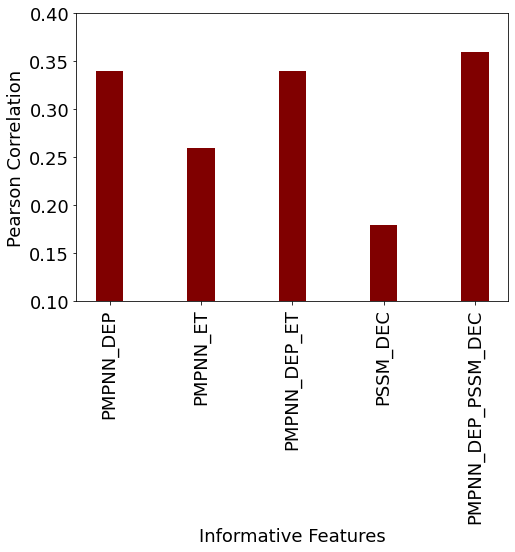

In [28]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0,0,1,1])
methods = ['PMPNN_DEP','PMPNN_ET','PMPNN_DEP_ET','PSSM_DEC','PMPNN_DEP_PSSM_DEC']
vals = [0.34,0.26,0.34,0.18,0.36]
plt.ylabel("Pearson Correlation",fontsize=18)
plt.xlabel("Informative Features",fontsize=18)
plt.xticks(fontsize=18, rotation=90)
plt.yticks(fontsize=18)
plt.ylim(0.10,0.40)
ax.bar(methods,vals,color="maroon",width=0.3)
plt.show()

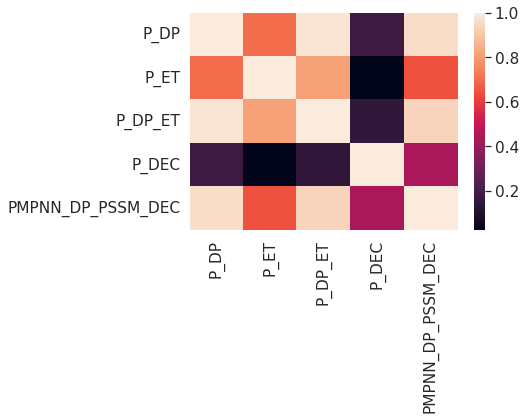

In [29]:
import pandas as pd
import seaborn as sns

mut_wild_predictions = np.array(mut_energies - wild_energies)
entropy_predictions = np.array(entropy_conservations)
first_second_combined = 0.5*mut_wild_predictions + 0.5*entropy_predictions
pssm_predictions = np.array(pssm_predictions)
first_pssm_combined = 0.89*mut_wild_predictions + 0.11*pssm_predictions

df_Ssym = pd.DataFrame(
    {'P_DP': mut_wild_predictions,
     'P_ET': entropy_predictions,
     'P_DP_ET':first_second_combined,
     'P_DEC': pssm_predictions,
     'PMPNN_DP_PSSM_DEC' : first_pssm_combined

    })
corr = df_Ssym.corr()

sns.set(font_scale=1.4)
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)